In [5]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta, date
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.plot import plot_cross_validation_metric
import joblib
import warnings

In [46]:
#!pip show statsmodels

In [6]:
def read_data():
  raw_data_link = 'https://raw.githubusercontent.com/Gervic/brent-oil-dashboard-fiap-tech-challenge-fase4/refs/heads/main/petrol_price_data.csv'
  raw_data = pd.read_csv(raw_data_link, sep=';')
  brent_data = raw_data[['Date', 'petrol_price']]
  brent_data['petrol_price'] = brent_data['petrol_price'].str.replace(',', '.').astype(float)
  return brent_data

In [7]:
df_brent = read_data()

<ipython-input-6-899eb80c6d8b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_data['petrol_price'] = brent_data['petrol_price'].str.replace(',', '.').astype(float)


### Basic checks

In [8]:
df_brent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4831 entries, 0 to 4830
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4831 non-null   object 
 1   petrol_price  4831 non-null   float64
dtypes: float64(1), object(1)
memory usage: 75.6+ KB


In [5]:
df_brent.describe().T

,count,mean,std,min,25%,50%,75%,max
petrol_price,4831.0,78.63658,25.196182,9.12,58.375,76.72,104.045,133.18


In [9]:
df_brent['Date'] = pd.to_datetime(df_brent['Date'])
df_brent = df_brent.sort_values(by='Date')
df_brent = df_brent.set_index('Date')

In [11]:
fig = go.Figure()

# Preço do petróleo
fig.add_trace(go.Scatter(
    x=df_brent.index,
    y=df_brent['petrol_price'],
    mode='lines',
    name='Preço Brent (USD)',
    line=dict(color='#1f77b4', width=2)
))

fig.update_layout(
    title="📉 Evolução dos Preços do Petróleo Brent",
    xaxis=dict(type='date'),
    xaxis_title="Data",
    yaxis_title="Preço (USD)",
    template="plotly_white",
    legend=dict(x=0, y=1),
    hovermode="x unified",
    height=600
)

Podemos ver que o preço teve longos períodos de altas e baixas. Provavelmente devido aos eventos econômicos e geopolíticos que houveram. Portanto, para realizar a predição, iremos usar os últimos 5 anos (2020/01 - presente) para evitar enviesar o modelo com essas oscilações atípicas do passado

### Modelagem com prophet

In [10]:
df_prophet = df_brent.copy()
df_prophet.reset_index(inplace=True)
df_prophet.columns = ['ds', 'y']

In [11]:
df_prophet = df_prophet.query("ds >= '2020-01-01' ")

In [12]:
m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpae32jnbz/myvyp25c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpae32jnbz/rn0jt8_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9501', 'data', 'file=/tmp/tmpae32jnbz/myvyp25c.json', 'init=/tmp/tmpae32jnbz/rn0jt8_4.json', 'output', 'file=/tmp/tmpae32jnbz/prophet_modely_is6d3d/prophet_model-20250518205038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:50:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:50:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [24]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1381,2025-05-28,72.746153,65.609039,79.476833
1382,2025-05-29,72.911977,65.743332,79.792673
1383,2025-05-30,73.236560,66.383180,79.953926
1384,2025-05-31,70.350633,63.574949,77.375608
1385,2025-06-01,73.444624,66.966727,80.404561


In [25]:
fig2 = plot_plotly(m, forecast)
fig2.update_layout(title='Previsão de Preço do Petroleo Brent com o modelo Prophet')
fig2.update_xaxes(title_text='Data')
fig2.update_yaxes(title_text='Preço do Petroleo Brent')
fig2.show()

In [28]:
plot_components_plotly(m, forecast)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [36]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '30 days')
# horizon: Period to be predicted.
# period -> Simulated forecast will be done at every this period. If not provided, 0.5 * horizon is used.
# initial: -> The first training period will include at least this much data.
df_p = performance_metrics(df_cv)

INFO:prophet:Making 7 forecasts with cutoffs between 2022-04-18 00:00:00 and 2025-04-02 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/a235_hnm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/xfece9vo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1980', 'data', 'file=/tmp/tmpnevi8oe0/a235_hnm.json', 'init=/tmp/tmpnevi8oe0/xfece9vo.json', 'output', 'file=/tmp/tmpnevi8oe0/prophet_modelf1kjdkur/prophet_model-20250518193641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:36:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/y3vkmuh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/e1va2fmr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [38]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
23,26 days,59.392051,7.706624,6.162685,0.067592,0.057114,0.068545,0.607143
24,27 days,43.974933,6.631360,5.215736,0.061410,0.050086,0.062277,0.642857
25,28 days,36.395371,6.032858,4.526804,0.055957,0.038990,0.055907,0.657143
26,29 days,40.217880,6.341757,4.923904,0.060834,0.041488,0.059436,0.571429
27,30 days,52.421320,7.240257,5.888115,0.071064,0.057752,0.068453,0.500000


In [39]:
# Adicionando eventos que impactaram o preço
events = pd.DataFrame([
    # Eventos históricos relevantes
    {'holiday': 'crise_2020', 'ds': '2020-02-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'crise_2022', 'ds': '2022-01-01', 'lower_window': 0, 'ds_upper': '2022-12-31'},

    # Eventos geopolíticos e econômicos recentes
    {'holiday': 'corte_producao_opec', 'ds': '2023-04-03', 'lower_window': 0, 'ds_upper': '2023-06-30'},
    {'holiday': 'guerra_russia_ucrania', 'ds': '2023-07-01', 'lower_window': 0, 'ds_upper': '2023-12-31'},
    {'holiday': 'conflito_oriente_medio', 'ds': '2024-01-01', 'lower_window': 0, 'ds_upper': '2024-03-31'},

    # Novos fatores externos relevantes
    {'holiday': 'pandemia_covid-19', 'ds': '2020-03-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'choque_precos_gas', 'ds': '2021-10-01', 'lower_window': 0, 'ds_upper': '2022-03-01'},
    {'holiday': 'colapso_banco_silicon', 'ds': '2023-03-10', 'lower_window': 0, 'ds_upper': '2023-03-30'},
    {'holiday': 'redução_estoques_petroleo', 'ds': '2024-05-01', 'lower_window': 0, 'ds_upper': '2024-06-30'},
    {'holiday': 'sanções_russia', 'ds': '2024-06-01', 'lower_window': 0, 'ds_upper': '2024-12-31'}
])

for col in ['ds', 'ds_upper']:
  events[col] = pd.to_datetime(events[col])
events['upper_window'] = (events['ds_upper'] - events['ds']).dt.days
events

,holiday,ds,lower_window,ds_upper,upper_window
0,crise_2020,2020-02-01,0,2021-03-01,394
1,crise_2022,2022-01-01,0,2022-12-31,364
2,corte_producao_opec,2023-04-03,0,2023-06-30,88
3,guerra_russia_ucrania,2023-07-01,0,2023-12-31,183
4,conflito_oriente_medio,2024-01-01,0,2024-03-31,90
5,pandemia_covid-19,2020-03-01,0,2021-03-01,365
6,choque_precos_gas,2021-10-01,0,2022-03-01,151
7,colapso_banco_silicon,2023-03-10,0,2023-03-30,20
8,redução_estoques_petroleo,2024-05-01,0,2024-06-30,60
9,sanções_russia,2024-06-01,0,2024-12-31,213


In [40]:
m2 = Prophet(holidays=events)
m2 = m2.fit(df_prophet)
future2 = m2.make_future_dataframe(periods=30)
forecast2 = m2.predict(future2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/_8xk11e6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/x_0hyg3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47631', 'data', 'file=/tmp/tmpnevi8oe0/_8xk11e6.json', 'init=/tmp/tmpnevi8oe0/x_0hyg3i.json', 'output', 'file=/tmp/tmpnevi8oe0/prophet_model2zggxpzr/prophet_model-20250518194328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [41]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1381,2025-05-28,72.746153,65.609039,79.476833
1382,2025-05-29,72.911977,65.743332,79.792673
1383,2025-05-30,73.236560,66.383180,79.953926
1384,2025-05-31,70.350633,63.574949,77.375608
1385,2025-06-01,73.444624,66.966727,80.404561


In [42]:
fig3 = plot_plotly(m2, forecast)
fig3.update_layout(title='Previsão de Preço do Petroleo Brent com o modelo Prophet')
fig3.update_xaxes(title_text='Data')
fig3.update_yaxes(title_text='Preço do Petroleo Brent')
fig3.show()

In [45]:
plot_components_plotly(m2, forecast)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [44]:
df_cv2 = cross_validation(m2, initial='730 days', period='180 days', horizon = '30 days')
# horizon: Period to be predicted.
# period -> Simulated forecast will be done at every this period. If not provided, 0.5 * horizon is used.
# initial: -> The first training period will include at least this much data.
df_p2 = performance_metrics(df_cv2)

INFO:prophet:Making 7 forecasts with cutoffs between 2022-04-18 00:00:00 and 2025-04-02 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/fgjicfy6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/k0598be_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53369', 'data', 'file=/tmp/tmpnevi8oe0/fgjicfy6.json', 'init=/tmp/tmpnevi8oe0/k0598be_.json', 'output', 'file=/tmp/tmpnevi8oe0/prophet_modeldg87yvyz/prophet_model-20250518194624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/sq36qxs5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnevi8oe0/zecke3r7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [46]:
df_p2.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
23,26 days,191.488198,13.837926,12.559862,0.153102,0.121374,0.140679,0.0
24,27 days,164.492544,12.825465,11.557833,0.144656,0.114004,0.133270,0.0
25,28 days,139.380020,11.805932,10.724341,0.136103,0.111058,0.126917,0.0
26,29 days,130.001236,11.401808,10.639836,0.133579,0.124576,0.126310,0.0
27,30 days,133.344813,11.547502,11.193837,0.137108,0.130961,0.130626,0.0


### Modelo Arima

In [13]:
df_arima = df_prophet.copy()
df_arima = df_arima.set_index('ds')

In [51]:
df_arima.iloc[[0, -1]]

,y
ds,
2020-01-02,67.05
2025-05-02,61.57


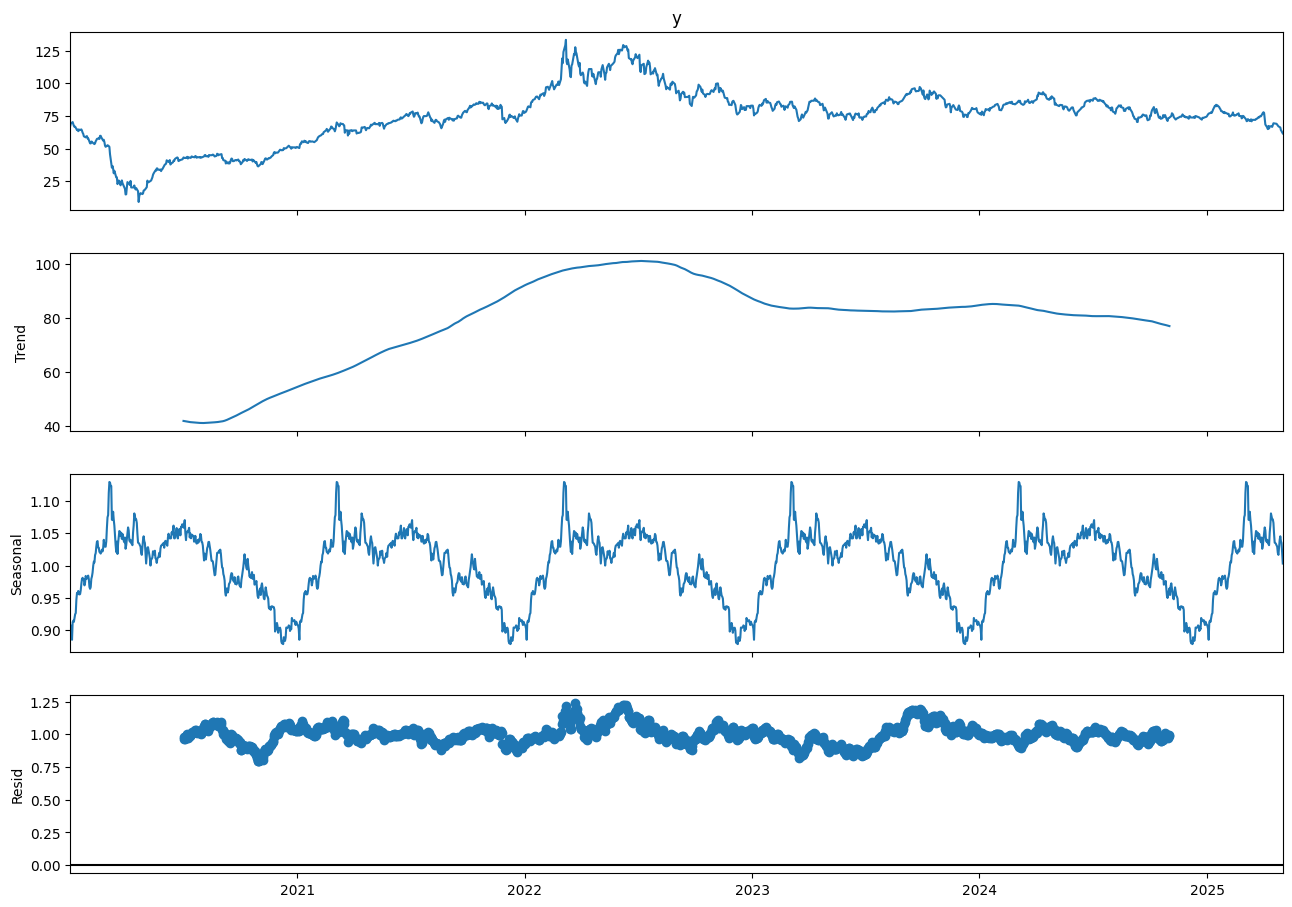

In [14]:
daily_data = df_arima['y'].resample('D').mean().interpolate(method='time')
result = seasonal_decompose(daily_data, model='multiplicative', period=365)
fig = result.plot()
fig.set_size_inches(14, 10)

In [15]:
# ADF test function
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {'ADF_Statistic': result[0], 'p-value': result[1], 'Critical_Values': result[4]}

daily_adf_result = adf_test(daily_data)
print(f"ADF_Statistic: {daily_adf_result['ADF_Statistic']}")
print(f"p-value: {daily_adf_result['p-value']}")

print('Critical Values:')
for key, value in daily_adf_result['Critical_Values'].items():
    print('\t%s: %.3f' % (key, value))

ADF_Statistic: -1.6195681535424227
p-value: 0.47295570580637813
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


p-value > 0.05, não rejeitamos a hipótese nula de que a série é não estacionária.

In [61]:
differenced_data = daily_data.diff().dropna()
differenced_adf_result = adf_test(differenced_data)

In [62]:
print(f"ADF_Statistic: {differenced_adf_result['ADF_Statistic']}")
print(f"p-value: {differenced_adf_result['p-value']}")

print('Critical Values:')
for key, value in differenced_adf_result['Critical_Values'].items():
    print('\t%s: %.3f' % (key, value))

ADF_Statistic: -10.22703773164642
p-value: 5.144501187389007e-18
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Após a diferenciação, temos um p-value próximo de zero, então podemos dizer que a série é não estacionária, ou seja, a média e variância estáveis ao longo do tempo

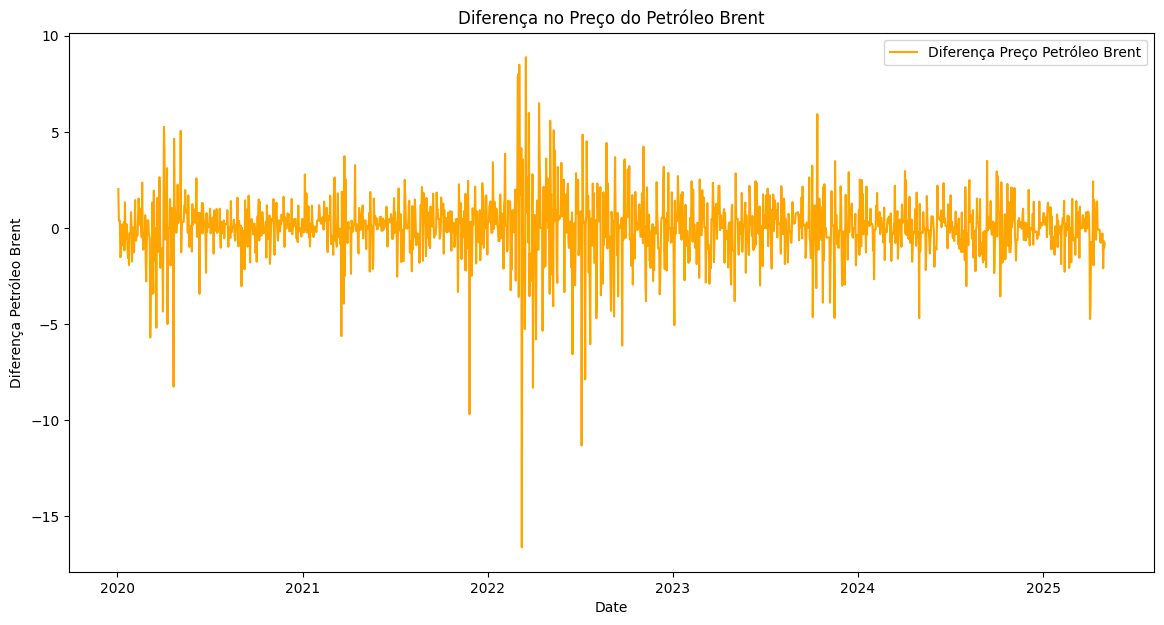

In [63]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(differenced_data.index, differenced_data, label='Diferença Preço Petróleo Brent', color='orange')
plt.title('Diferença no Preço do Petróleo Brent')
plt.xlabel('Date')
plt.ylabel('Diferença Petróleo Brent')
plt.legend()
plt.show()

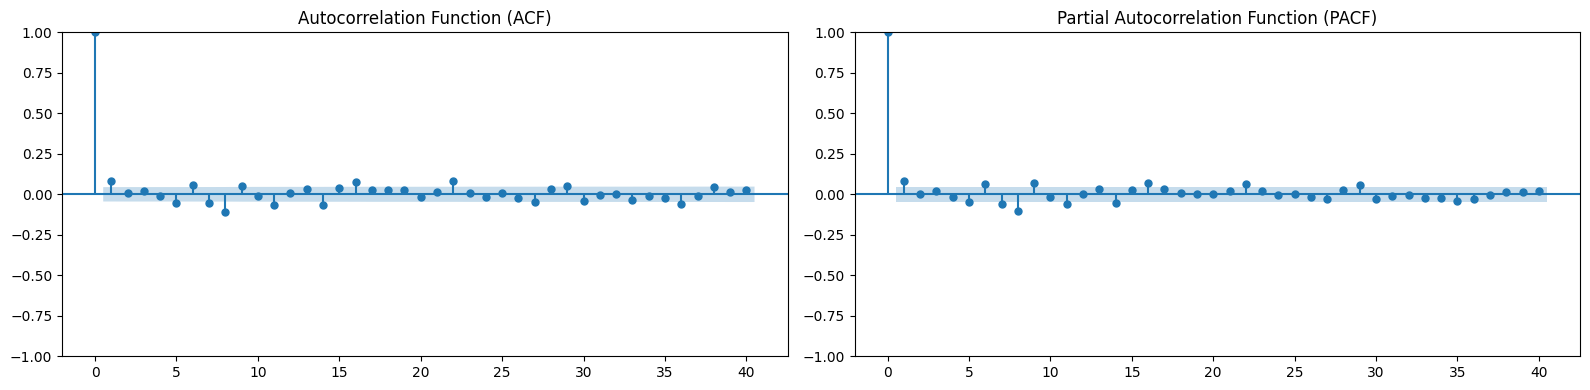

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(differenced_data, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(differenced_data, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Com base nesses gráficos, podemos ver que o ACF corta a linha pontilhada azul na lag 1, enquanto o PACF corta a linha pontilhada azul na lag 1. Isso sugere que um modelo ARIMA(1,1,1) pode ser adequado para a série temporal já que fizemos 1 diferenciação.

In [23]:
def find_best_arima_model(time_series, p_range=range(0, 4), d_range=range(0, 3), q_range=range(0, 4)):
  best_aic = np.inf
  best_order = None
  best_model = None

  print("Searching best ARIMA(p,d,q)...")

  for p in p_range:
    for d in d_range:
      for q in q_range:
        try:
            with warnings.catch_warnings():
              warnings.filterwarnings("ignore")
              model = ARIMA(time_series, order=(p, d, q))
              model_fit = model.fit()
              aic = model_fit.aic
              #print(f"ARIMA({p},{d},{q}) AIC: {aic:.2f}")
              if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
                best_model = model_fit
        except:
          continue

  print(f"\n✅ Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")
  return best_order, best_model

In [24]:
best_order, best_model = find_best_arima_model(daily_data)

Searching best ARIMA(p,d,q)...

✅ Best ARIMA order: (3, 1, 2) with AIC: 7055.11


In [25]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1948
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3521.555
Date:                Sun, 18 May 2025   AIC                           7055.110
Time:                        20:59:05   BIC                           7088.554
Sample:                    01-02-2020   HQIC                          7067.407
                         - 05-02-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6126      0.025    -24.404      0.000      -0.662      -0.563
ar.L2         -0.8366      0.021    -39.442      0.000      -0.878      -0.795
ar.L3          0.1357      0.016      8.308      0.0

In [28]:
# Modelagem com ARIMA
closing_prices = df_arima['y'].sort_index()
train_data = closing_prices[:'2023-12-31']
test_periods = pd.date_range('2024-01-01', periods=365, freq='B')

model_arima = ARIMA(train_data, order=(3,1,2))
model_fit = model_arima.fit()

forecast_arima = model_fit.get_forecast(steps=len(test_periods))
forecast_values = forecast_arima.predicted_mean
forecast_values_lower = forecast_arima.conf_int(alpha=0.05).iloc[:, 0]
forecast_values_upper = forecast_arima.conf_int(alpha=0.05).iloc[:, 1]

df_forecast = pd.DataFrame({
    'Data': test_periods,
    'Previsão': forecast_values,
    'Intervalo Inferior': forecast_values_lower,
    'Intervalo Superior': forecast_values_upper
})

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

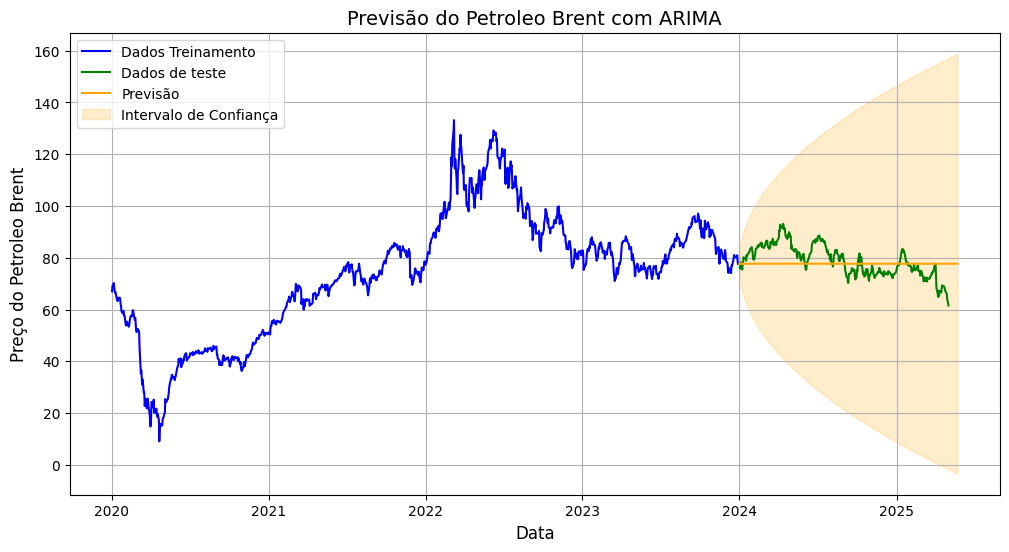

In [29]:
# Plotando os resultados
plt.figure(figsize=(12, 6))

# Dados históricos
plt.plot(train_data.index, train_data, label='Dados Treinamento', color='blue')
plt.plot(closing_prices['2023-12-31':].index, closing_prices['2023-12-31':], label='Dados de teste', color='green')
# Previsões com intervalos de confiança
plt.plot(df_forecast['Data'], df_forecast['Previsão'], label='Previsão', color='orange')
plt.fill_between(
    df_forecast['Data'],
    df_forecast['Intervalo Inferior'],
    df_forecast['Intervalo Superior'],
    color='orange', alpha=0.2, label='Intervalo de Confiança'
)

# Adicionando rótulos e título
plt.title('Previsão do Petroleo Brent com ARIMA', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço do Petroleo Brent', fontsize=12)
plt.legend()
plt.grid()

In [30]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 4434.261103172314
BIC: 4463.808777548605


In [31]:
forecast_ar = forecast_values[:len(closing_prices['2024-01-02':])]
test_close = closing_prices['2024-01-02':]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast_ar))
print(f"RMSE: {rmse:.4f}")

RMSE: 6.1809


In [32]:
joblib.dump(model_fit, 'arima_model.pkl')

['arima_model.pkl']

In [33]:
joblib.dump(m, 'prophet_model.pkl')

['prophet_model.pkl']